In [ ]:
'''
GNU LESSER GENERAL PUBLIC LICENSE
Version 3, 29 June 2007.
Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>.
Everyone is permitted to copy and distribute verbatim copies of this 
license document, but changing it is not allowed.
'''

# The Transportation Simplex
## Automated Simulation in GIS
---

### James Gaboardi, 2015

--------------------

## Imports & Set Up

In [1]:
# Imports
import pysal as ps
import geopandas as gpd
import numpy as np
import networkx as nx
import shapefile as shp
from shapely.geometry import Point
import shapely
from collections import OrderedDict
import pandas as pd
import qgrid
import gurobipy as gbp
import time
import bokeh
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook, output_file, show
from bokeh.models import (HoverTool, BoxAnnotation, GeoJSONDataSource, 
                          GMapPlot, GMapOptions, ColumnDataSource, Circle, 
                          DataRange1d, PanTool, WheelZoomTool, BoxSelectTool,
                          ResetTool, MultiLine)
import utm
import matplotlib.pyplot as plt
import matplotlib as mpl

# MatPlotLib for Visualizations inline
%matplotlib inline

# Local path on user's machine
path = '/Users/jgaboardi/Transport/Data/'
#path = 'path/to/data/'

# Set Random Seed
np.random.seed(352)

# Out inline notebook for Bokeh
output_notebook()

/Users/jgaboardi/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading BokehJS ...

## Data preparation and creation

### Reproject the street network with `GeoPandas`

In [2]:
# Waverly  Hills
STREETS = gpd.read_file(path+'Waverly_Trim/Waverly.shp')
STREETS.to_crs(epsg=2779, inplace=True) # NAD83(HARN) / Florida North
STREETS.to_file(path+'WAVERLY/WAVERLY.shp')
STREETS[:5]

ACCESS_ ALIAS_NAME BUILT_DATE BUILT_STAT  CLASS CONN_TYPE COUNTY    EDIT_BY  \
0    None    SR - 61       None      BUILT      8      CONN   LEON  HAGESETHC   
1    None    SR - 61       None      BUILT      8      INTE   LEON  HAGESETHC   
2    None    SR - 61       None      BUILT      8      CONN   LEON  HAGESETHC   
3    None    SR - 61       None      BUILT      8      CONN   LEON  HAGESETHC   
4    None    SR - 61       None      BUILT      8      CONN   LEON  HAGESETHC   

    EDIT_DATE EDIT_TYPE                        ...                          \
0  2014-02-26         O                        ...                           
1  2014-02-26         O                        ...                           
2  2014-02-26         O                        ...                           
3  2014-02-26         O                        ...                           
4  2014-02-26         O                        ...                           

        SOURCE SPEED  STATUS  SUFFIX   TF_COST THEOR_RANG  TRAVEL_FLA  TYPE  \
0   DOP2008TFC     5       O    None  0.090264          N           2    RD   
1  FDOR2007TFC    25       O    None  0.017222          N           2    RD   
2   DOP2008TFC     5       O    None  0.091403          N           2    RD   
3   DOP2008TFC     5       O    None  0.090467          N           2    RD   
4   DOP2008TFC     5       O    None  0.089032          N           2    RD   

   T_ELEV                                           geometry  
0       0  LINESTRING (623093.510832076 164171.1041567803...  
1       0  LINESTRING (622515.1922320754 163214.635256776...  
2       0  LINESTRING (623548.0931320738 165478.253356780...  
3       0  LINESTRING (623167.8413320724 164328.903156780...  
4       0  LINESTRING (623546.4237320729 165409.808056779...  

[5 rows x 46 columns]

### Plot Waverly Hills

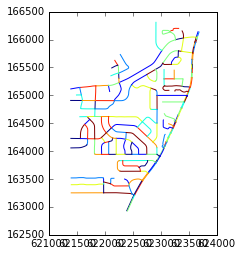

In [3]:
STREETS.plot()

### Instantiate Network and read in `WAVERLY.shp`

In [4]:
ntw = ps.Network(path+'WAVERLY/WAVERLY.shp')
shp_W = ps.open(path+'WAVERLY/WAVERLY.shp')

### Create Buffer of 200 meters

In [5]:
buff = STREETS.buffer(200)  #Buffer
buff[:5]

0    POLYGON ((623182.150053937 164350.7973140236, ...
1    POLYGON ((622609.2522032181 163391.5139959676,...
2    POLYGON ((623558.0958294807 165678.3788460373,...
3    POLYGON ((623266.5120703815 164503.29148902, 6...
4    POLYGON ((623558.3641320487 165609.8080567809,...
dtype: object

### Plot Buffers of Individual Streets

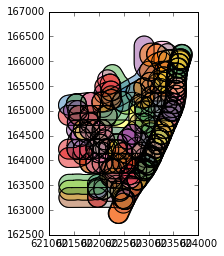

In [6]:
buff.plot()

### Create a Unary Union of the individual street buffers

In [7]:
buffU = buff.unary_union  #Buffer Union
buff1 = gpd.GeoSeries(buffU)
buff1.crs = STREETS.crs
Buff = gpd.GeoDataFrame(buff1, crs=STREETS.crs)
Buff.columns = ['geometry']
Buff

geometry
0  POLYGON ((622673.874236838 163055.508300971, 6...

### Plot the unary union buffer

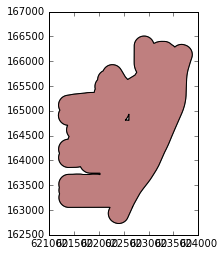

In [8]:
Buff.plot()

### Create 1000 random points within the bounds of `WAVERLY.shp`

In [9]:
np.random.seed(352)
x = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 100)
np.random.seed(850)
y = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 100)  
coords0= zip(x,y)
coords = [shapely.geometry.Point(i) for i in coords0]
Rand = gpd.GeoDataFrame(coords)
Rand.crs = STREETS.crs
Rand.columns = ['geometry']
Rand[:5]

geometry
0  POINT (623388.4926405598 166286.4795721661)
1  POINT (622672.4092589854 162943.9994787998)
2  POINT (621913.3153830337 164903.3379650218)
3  POINT (621612.0857702466 164217.1288344094)
4  POINT (623414.8982675247 163698.4405537729)

### Plot the 1000 random 

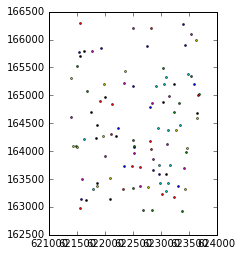

In [10]:
Rand.plot()

### Create `GeoPandas` DF of the random points within the Unary Buffer

In [11]:
Inter = [Buff['geometry'].intersection(p) for p in Rand['geometry']]
INTER = gpd.GeoDataFrame(Inter, crs=STREETS.crs)
INTER.columns = ['geometry']
INTER[:5]

geometry
0  POINT (623388.4926405598 166286.4795721661)
1                                           ()
2  POINT (621913.3153830337 164903.3379650218)
3  POINT (621612.0857702466 164217.1288344094)
4                                           ()

### Plot the points within the Unary Buffer

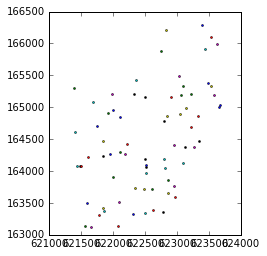

In [12]:
INTER.plot()

### Add only intersecting records to a list 

In [13]:
# Add records that are points within the buffer
point_in = []
for p in INTER['geometry']:
    if type(p) == shapely.geometry.point.Point:
        point_in.append(p)
point_in[:5]

### Keep the first 5 for Supply facilities and the last 10 for Demand facilities

In [14]:
SUPPLY = gpd.GeoDataFrame(point_in[:5], crs=STREETS.crs)
SUPPLY.columns = ['geometry']
DEMAND = gpd.GeoDataFrame(point_in[-10:], crs=STREETS.crs)
DEMAND.columns = ['geometry']
SUPPLY.to_file(path+'SUPPLY')
DEMAND.to_file(path+'DEMAND')

In [17]:
SUPPLY[:2]

geometry
0  POINT (623388.4926405598 166286.4795721661)
1  POINT (621913.3153830337 164903.3379650218)

In [16]:
DEMAND[:2]

geometry
0   POINT (621383.7752160889 165304.858405704)
1  POINT (622220.6222151037 164417.1261164876)

### Instaniate non-solution graphs to be drawn

In [ ]:
# Roads and Nodes
g = nx.Graph()
# Graph of Roads and Nodes
g1 = nx.MultiGraph()
# Clients
GRAPH_supply = nx.Graph()
# Snapped Supply
g_supply = nx.Graph()
# Demand
GRAPH_demand = nx.Graph()
# Snapped Demand
g_demand = nx.Graph()

### Instantiate and fill Supply and Demand point dictionaries

In [ ]:
points_supply = {} 
points_demand = {}

SPLY = ps.open(path+'SUPPLY/SUPPLY.shp')
for idx, coords in enumerate(SPLY):
    GRAPH_supply.add_node(idx)
    points_supply[idx] = coords
    GRAPH_supply.node[idx] = coords
    
DMND = ps.open(path+'DEMAND/DEMAND.shp')
for idx, coords in enumerate(DMND):
    GRAPH_demand.add_node(idx)
    points_demand[idx] = coords
    GRAPH_demand.node[idx] = coords

### Create Simulated Supply and Demand

In [ ]:
# Supply
Si = np.random.randint(50, 200, 5)
Si = Si.reshape(100,1)
SiSum = np.sum(Si)
# Demand
Dj = np.random.randint(10, 100, 10)

DjSum = np.sum(Dj)

<font size='5' face='Times New Roman'><b>1.8 <u>Draw graphs of roads, simplified network, and random supply & demand nodes</u></b></font>

In [ ]:
#Instantiate Figure
figsize(10,10)
# Draw Graph of Actual Nodes and Roads
for e in ntw.edges:
    g.add_edge(*e)
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)
# Draw only unique edges in graph
for e in ntw.graphedges:
    g1.add_edge(*e)
    # highlights cases where start and end node are the same
    if e[0]==e[1]:
        g1.add_node(e[0])
for node_id in g1.node:
    g1.node[node_id] = ntw.node_coords[node_id]
nx.draw(g1, ntw.node_coords, node_size=10, alpha=0.5)
# Draw Graph of Random Supply Points
nx.draw(GRAPH_supply, points_supply, 
    node_size=75, alpha=1, node_color='b')
# Draw Graph of Random Demand Points
nx.draw(GRAPH_demand, points_demand, 
    node_size=100, alpha=1, node_color='c')
# Legend (Ordered Dictionary)
LEGEND = OrderedDict()
LEGEND['Network Nodes']=g
LEGEND['Roads']=g
LEGEND['Graph Vertices']=g1
LEGEND['Graph Edges']=g1
LEGEND['Supply Nodes']=GRAPH_supply
LEGEND['Demand Nodes']=GRAPH_demand
legend(LEGEND, loc='best')
# Title
title('Waverly Hills\n Tallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')

<font size='5' face='Times New Roman'><b>1.9 <u>Create Supply and Demand</u></b></font>

<font size='5' face='Times New Roman'><b>1.10 <u>Instantiate supply and demand shapefiles</u></b></font>

In [ ]:
# Convert store SUPPLY locations to LatLon
supply_locations = SPLY
supply_locations.to_crs(epsg=32616, inplace=True) # UTM 16N
supply_locations_LonLat_Dict = OrderedDict()
supply_locations_LonLat_List = []

for i,j in supply_locations['geometry'].iteritems():
    supply_locations_LonLat_Dict[y_list[i]] = utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')  
    supply_locations_LonLat_Dict.append((utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')))

supply_locations_Lat_List = []
supply_locations_Lon_List = []
    
for i in supply_locations_LonLat_List:
    supply_locations_Lat_List.append(i[0])
for i in supply_locations_LonLat_List:
    supply_locations_Lon_List.append(i[1])
    
    
# Convert store DEMAND locations to LatLon
demand_locations = DMND
demand_locations.to_crs(epsg=32616, inplace=True) # UTM 16N
demand_locations_LonLat_Dict = OrderedDict()
demand_locations_LonLat_List = []

for i,j in demand_locations['geometry'].iteritems():
    demand_locations_LonLat_Dict[y_list[i]] = utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')  
    demand_locations_LonLat_Dict.append((utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')))

demand_locations_Lat_List = []
demand_locations_Lon_List = []
    
for i in demand_locations_LonLat_List:
    demand_locations_Lat_List.append(i[0])
for i in demand_locations_LonLat_List:
    demand_locations_Lon_List.append(i[1])

In [ ]:
# Supply
supply_SHP = shp.Writer(shp.POINT)
# Add Random Points
for i,j in rand_coords_supply:
    supply.point(i,j)
# Add Fields
supply_SHP.field('Si_ID')
supply_SHP.field('Supply')
supply_SHP.field('LAT')
supply_SHP.field('LON')
counter = 0
for i in range(len(rand_coords_supply)):
    counter = counter + 1
    supply_SHP.record('x'+ str(counter)+'_--', Si[i], supply_locations_Lat_List[i], supply_locations_Lon_List[i])
# Save Shapefile    
supply_SHP.save('path.../RandomPoints_SUPPLY')

#Demand
demand = shp.Writer(shp.POINT)
# Add Random Points
for i,j in rand_coords_demand:
    demand.point(i,j)
# Add Fields
demand.field('Dj_ID_x')
demand.field('Demand')
demand.field('LAT')
demand.field('LON')
counter = 0
for i in range(len(rand_coords_demand)):
    counter = counter + 1
    demand.record('x--_'+ str(counter), Dj[i], demand_locations_Lat_List[i], demand_locations_Lon_List[i])
# Save Shapefile    
demand.save('path.../RandomPoints_DEMAND')

<font size='5' face='Times New Roman'><b>1.11 <u>Snap Observations to NTW</u></b></font>

In [ ]:
t1 = time.time()
ntw.snapobservations('shapefiles/RandomPoints_SUPPLY.shp', 
                     'Rand_Points_SUPPLY', attribute=True)
ntw.snapobservations('shapefiles/RandomPoints_DEMAND.shp', 
                     'Rand_Points_DEMAND', attribute=True)
print round(time.time()-t1, 4), 'seconds'

<font size='5' face='Times New Roman'><b>1.12 <u>Draw NTW, snapped coords, & random coords</u></b></font>

In [ ]:
# Instantiate Figure
figsize(10,10)
# Draw Graph of Roads
for e in ntw.edges:
    g.add_edge(*e)
nx.draw(g, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)
# Draw Graph of Snapped Supply Nodes
g_supply = nx.Graph()
for p,coords in ntw.pointpatterns['Rand_Points_SUPPLY'].snapped_coordinates.iteritems():
    g_supply.add_node(p)
    g_supply.node[p] = coords
nx.draw(g_supply, ntw.pointpatterns['Rand_Points_SUPPLY'].snapped_coordinates, 
        node_size=100, alpha=1, node_color='b')
# Draw Graph of Snapped Demand Nodes
g_service = nx.Graph()
for p,coords in ntw.pointpatterns['Rand_Points_DEMAND'].snapped_coordinates.iteritems():
    g_demand.add_node(p)
    g_demand.node[p] = coords
nx.draw(g_demand, ntw.pointpatterns['Rand_Points_DEMAND'].snapped_coordinates, 
        node_size=100, alpha=1, node_color='c')
# Draw Graph of Random Supply Points
nx.draw(GRAPH_supply, points_supply, 
    node_size=20, alpha=1, node_color='y')
# Draw Graph of Random Demand Points
nx.draw(GRAPH_demand, points_demand, 
    node_size=20, alpha=1, node_color='w')

# Legend (Ordered Dictionary)
LEGEND = OrderedDict()
LEGEND['Network Nodes']=g
LEGEND['Roads']=g
LEGEND['Snapped Supply']=g_supply
LEGEND['Snapped Demand']=g_demand
LEGEND['Supply Nodes']=GRAPH_supply
LEGEND['Demand Nodes']=GRAPH_demand

legend(LEGEND, loc='best')
# Title
title('Waverly Hills\n Tallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')

<font size='5' face='Times New Roman'><b>1.13 <u>Create distance matrix</u></b></font>

In [ ]:
t1 = time.time()
All_Neigh_Dist = ntw.allneighbordistances(sourcepattern=ntw.pointpatterns['Rand_Points_SUPPLY'],
                                       destpattern=ntw.pointpatterns['Rand_Points_DEMAND'])
All_Dist_MILES = All_Neigh_Dist * float(10000/90) * 0.6214
seconds = round(time.time()-t1, 4)
print seconds, 'seconds'
print 'Supply to Demand Matrix Shape --> ', All_Dist_MILES.shape

<font size='7' face='Times New Roman'><b>2. <u>Optimize</u></b></font>

In [ ]:

import numpy as np
import gurobipy as gbp
import time
np.random.seed(352)

def GuTransProb(Cij, Si, Dj):
    t1 = time.time()
    #  Data
    
    Cij = Cij.reshape(matrix_rows,matrix_cols)
    Si = Si.reshape(matrix_rows,1)
    Dj = Dj.reshape(matrix_cols,1)
    
    # Indices & Variable Names
    supply_nodes = len(Cij)
    demand_nodes = len(Cij[0])
    supply_nodes_range = range(len(Cij))
    demand_nodes_range = range(len(Cij[0]))
    all_nodes_len = len(Cij) * len(Cij[0])
    ALL_nodes_range = range(all_nodes_len)
    
    # Create Model, Set MIP Focus, Add Variables, & Update Model
    m = gbp.Model(' -- The Transportation Problem -- ')
    # Set MIP Focus to 2 for optimality
    gbp.setParam('MIPFocus', 2)
    descision_var = []
    for orig in supply_nodes_range:
        descision_var.append([])
        for dest in demand_nodes_range:
            descision_var[orig].append(m.addVar(vtype=gbp.GRB.CONTINUOUS, 
                                            obj=Cij[orig][dest], 
                                            name='x'+str(orig+10001)+'_'+str(dest+10001)))
    # Update Model Variables
    m.update()       
    
    #  Set Objective Function
    m.setObjective(gbp.quicksum(Cij[orig][dest]*descision_var[orig][dest] 
                            for orig in supply_nodes_range for dest in demand_nodes_range), 
                            gbp.GRB.MINIMIZE)
                            
    # Add Supply Constraints
    for orig in supply_nodes_range:
        m.addConstr(gbp.quicksum(descision_var[orig][dest] 
                            for dest in demand_nodes_range) - Si[orig] <= 0)
    # Add Demand Constraints
    for orig in demand_nodes_range:  
        m.addConstr(gbp.quicksum(descision_var[dest][orig] 
                            for dest in supply_nodes_range) - Dj[orig] >= 0)
    
    #  Optimize and Print Results
    try:
        m.optimize()
    except Exception as e:
        print e
        
    t2 = time.time()-t1
    print '******************************************************************************'
    print '| From SUPPLY Facility to DEMAND Facility x(Si)_(Dj) shipping # of units  '
    print '| ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓'
    print '|'
    selected = {}
    Closed = []
    for v in m.getVars():
        var = '%s' % v.VarName
        if v.x > 0:
            units = '%i' % v.x
            selected[var] = units
            print '|  Supply Facility #', var[1:6], 'is shipping', units, \
                                                'units to Demand Facility #', var[-5:]
        else:
            Closed.append([var[1:6], var[-5:]])
    print '******************************************************************************'
    print '    | Objective Value --------------------- ', int(m.objVal)
    print '    | Supply Facilities ------------------- ', len(Si)
    print '    | Total Supply Units ------------------ ', Si.sum()
    print '    | Demand Facilites -------------------- ', len(Dj)
    print '    | Total Demand Units ------------------ ', Dj.sum()
    print '    | Total Potential Combinations -------- ', len(Si)*len(Dj)
    print '    | Actual Combinations  ---------------- ', len(selected)
    print '    | Real Time to Optimize (sec.) -------- ', t2
    print '******************************************************************************'
    print '  --  The Transportation Simplex with Gurobi --'
    m.write('path.lp')
    
#########################################################################################
# Data can be read-in or simulated
    
Supply = np.random.randint(50,200,5)   # Vector of Units Supplied
Demand = np.random.randint(25,30,7)    # Vector of Units Demanded

matrix_rows = len(Supply)                # Supply (i) x Demand (j)
matrix_cols = len(Demand)

Cost_Matrix = np.random.randint(3, 
                                50, 
                                matrix_rows*matrix_cols)
# Call Function   
try:
    GuTransProb(Cij=Cost_Matrix, Si=Supply, Dj=Demand)
    print '\nJames Gaboardi, 2016'
    print '*******************************************************************'\
                                        '**********************\n\n'
except Exception as e:
    print e